In [ ]:
!pip install pyinform

In [ ]:
!pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pyinform.transferentropy import transfer_entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [ ]:
dow_jones_df = pd.read_csv('/content/DOW_JONES_5Y.csv')
nasdaq_df = pd.read_csv('/content/NASDAQ_5Y.csv')
sp_df = pd.read_csv('/content/SP_5Y.csv')

dow_jones_df.head(), nasdaq_df.head(), sp_df.head()

(         Date       Open       High        Low      Close
 0  04/12/2024  38,319.14  38,319.14  37,877.30  37,983.24
 1  04/11/2024  38,523.26  38,598.98  38,197.28  38,459.08
 2  04/10/2024  38,662.28  38,662.28  38,304.66  38,461.51
 3  04/09/2024  38,983.66  38,992.89  38,572.09  38,883.67
 4  04/08/2024  38,916.42  39,013.20  38,857.70  38,892.80,
          Date  Close/Last      Open      High       Low
 0  04/12/2024    16175.09  16293.03  16341.46  16125.33
 1  04/11/2024    16442.20  16236.20  16464.60  16154.65
 2  04/10/2024    16170.36  16104.01  16200.10  16092.02
 3  04/09/2024    16306.64  16328.76  16348.18  16141.15
 4  04/08/2024    16253.96  16285.18  16323.60  16220.72,
          Date      Open      High       Low     Close
 0  04/12/2024  5,171.51  5,175.03  5,107.94  5,123.41
 1  04/11/2024  5,172.95  5,211.78  5,138.77  5,199.06
 2  04/10/2024  5,167.88  5,178.43  5,138.70  5,160.64
 3  04/09/2024  5,217.03  5,224.81  5,160.78  5,209.91
 4  04/08/2024  5,211.37  5

In [ ]:
nasdaq_df.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [ ]:
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.set_index('Date', inplace=True)
sp_df['Close'] = sp_df['Close'].str.replace(',', '').astype(float)
sp_df.sort_index(ascending=True, inplace=True)

dow_jones_df['Date'] = pd.to_datetime(dow_jones_df['Date'])
dow_jones_df.set_index('Date', inplace=True)
dow_jones_df['Close'] = dow_jones_df['Close'].str.replace(',', '').astype(float)
dow_jones_df.sort_index(ascending=True, inplace=True)

nasdaq_df['Date'] = pd.to_datetime(nasdaq_df['Date'])
nasdaq_df.set_index('Date', inplace=True)
nasdaq_df['Close'] = nasdaq_df['Close'].astype(float)
nasdaq_df.sort_index(ascending=True, inplace=True)


sp_train_end_date = sp_df.index.max() - pd.DateOffset(years=1)
sp_train_df = sp_df.loc[:sp_train_end_date]
sp_test_df = sp_df.loc[sp_train_end_date + pd.DateOffset(days=1):]

dow_jones_train_end_date = dow_jones_df.index.max() - pd.DateOffset(years=1)
dow_jones_train_df = dow_jones_df.loc[:dow_jones_train_end_date]
dow_jones_test_df = dow_jones_df.loc[dow_jones_train_end_date + pd.DateOffset(days=1):]

nasdaq_train_end_date = nasdaq_df.index.max() - pd.DateOffset(years=1)
nasdaq_train_df = nasdaq_df.loc[:nasdaq_train_end_date]
nasdaq_test_df = nasdaq_df.loc[nasdaq_train_end_date + pd.DateOffset(days=1):]

sp_train_df.tail(), sp_test_df.head(), dow_jones_train_df.tail(), dow_jones_test_df.head(), nasdaq_train_df.tail(), nasdaq_test_df.head()

(                Open      High       Low    Close
 Date                                             
 2023-04-05  4,094.50  4,099.69  4,072.56  4090.38
 2023-04-06  4,081.58  4,107.32  4,069.84  4105.02
 2023-04-10  4,085.20  4,109.50  4,072.55  4109.11
 2023-04-11  4,110.29  4,124.26  4,102.61  4108.94
 2023-04-12  4,121.72  4,134.37  4,086.94  4091.95,
                 Open      High       Low    Close
 Date                                             
 2023-04-13  4,100.04  4,150.26  4,099.40  4146.22
 2023-04-14  4,140.11  4,163.19  4,113.20  4137.64
 2023-04-17  4,137.17  4,151.72  4,123.18  4151.32
 2023-04-18  4,164.26  4,169.48  4,140.36  4154.87
 2023-04-19  4,139.33  4,162.57  4,134.49  4154.52,
                  Open       High        Low     Close
 Date                                                 
 2023-04-05  33,394.60  33,543.84  33,376.27  33482.72
 2023-04-06  33,420.96  33,525.96  33,325.37  33485.29
 2023-04-10  33,425.25  33,590.24  33,343.43  33586.52
 2023-04-

In [ ]:
def adf_test(timeseries):
    result = adfuller(timeseries.dropna(), autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations Used': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%']
    }
    return output

adf_results_dow = adf_test(sp_train_df['Close'])
adf_results_nasdaq = adf_test(dow_jones_train_df['Close'])
adf_results_sp = adf_test(nasdaq_train_df['Close'])

adf_results_dow, adf_results_nasdaq, adf_results_sp

({'Test Statistic': -1.5089125912873849,
  'p-value': 0.5290978904698121,
  'Lags Used': 10,
  'Number of Observations Used': 1005,
  'Critical Value (1%)': -3.4368734638130847,
  'Critical Value (5%)': -2.8644201518188126,
  'Critical Value (10%)': -2.5683035273879358},
 {'Test Statistic': -1.6681797720876061,
  'p-value': 0.447577252641267,
  'Lags Used': 10,
  'Number of Observations Used': 1005,
  'Critical Value (1%)': -3.4368734638130847,
  'Critical Value (5%)': -2.8644201518188126,
  'Critical Value (10%)': -2.5683035273879358},
 {'Test Statistic': -1.5862464121275175,
  'p-value': 0.49049862869465216,
  'Lags Used': 11,
  'Number of Observations Used': 1004,
  'Critical Value (1%)': -3.436879978012783,
  'Critical Value (5%)': -2.86442302475405,
  'Critical Value (10%)': -2.568305057578451})

*   DOW JONES: The p-value is above 0.05, indicating that we cannot reject the null hypothesis. This suggests that the Dow Jones closing price series is not stationary.
*   NASDAQ: The p-value is significantly above 0.05, indicating that the Nasdaq closing price series is not stationary.
*   S&P: The p-value is above 0.05, indicating that the S&P 500 closing price series is not stationary.



In [ ]:
dow_jones_df['Close_DOW_diff'] = dow_jones_df['Close'].diff()
nasdaq_df['Close_NASDAQ_diff'] = nasdaq_df['Close'].diff()
sp_df['Close_SP_diff'] = sp_df['Close'].diff()

adf_results_dow_diff = adf_test(dow_jones_df['Close_DOW_diff'])
adf_results_nasdaq_diff = adf_test(nasdaq_df['Close_NASDAQ_diff'])
adf_results_sp_diff = adf_test(sp_df['Close_SP_diff'])

adf_results_dow_diff, adf_results_nasdaq_diff, adf_results_sp_diff

({'Test Statistic': -10.723666950026319,
  'p-value': 3.1045763740052345e-19,
  'Lags Used': 8,
  'Number of Observations Used': 1258,
  'Critical Value (1%)': -3.4355588184378574,
  'Critical Value (5%)': -2.8638402312881497,
  'Critical Value (10%)': -2.5679946684494275},
 {'Test Statistic': -11.234320829360687,
  'p-value': 1.8736820550499014e-20,
  'Lags Used': 8,
  'Number of Observations Used': 1258,
  'Critical Value (1%)': -3.4355588184378574,
  'Critical Value (5%)': -2.8638402312881497,
  'Critical Value (10%)': -2.5679946684494275},
 {'Test Statistic': -10.874950165201863,
  'p-value': 1.3389958817646568e-19,
  'Lags Used': 8,
  'Number of Observations Used': 1258,
  'Critical Value (1%)': -3.4355588184378574,
  'Critical Value (5%)': -2.8638402312881497,
  'Critical Value (10%)': -2.5679946684494275})



*   Dow Jones (Close_DOW_diff): The p-value is extremely low, indicating strong evidence against the null hypothesis. We can conclude that the differenced Dow Jones series is stationary.
*   Nasdaq (Close_NASDAQ_diff): The p-value is extremely low. This indicates that the Nasdaq series, after differencing, is stationary.
*   S&P 500 (Close_SP_diff): The p-value is very low, indicating that the differenced S&P 500 series is stationary.






The date range for both datasets is from April 1, 2019, to April 11, 2024. We'll use data from April 1, 2019, to March 31, 2023, for training, and data from April 1, 2023, to April 11, 2024, for testing.

Using Nasdaq to predict S&P500

In [ ]:
pd.options.mode.chained_assignment = None

num_bins = 10

nasdaq_train_df.loc[:, 'binned'] = pd.qcut(nasdaq_train_df['Close'], q=num_bins, labels=False, duplicates='drop')
sp_train_df.loc[:, 'binned'] = pd.qcut(sp_train_df['Close'], q=num_bins, labels=False, duplicates='drop')

te_nasdaq_to_sp = transfer_entropy(nasdaq_train_df['binned'], sp_train_df['binned'], k=1, local=False)

print("Transfer entropy from NASDAQ to S&P 500:", te_nasdaq_to_sp)

Transfer entropy from NASDAQ to S&P 500: 0.11042230752063457


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

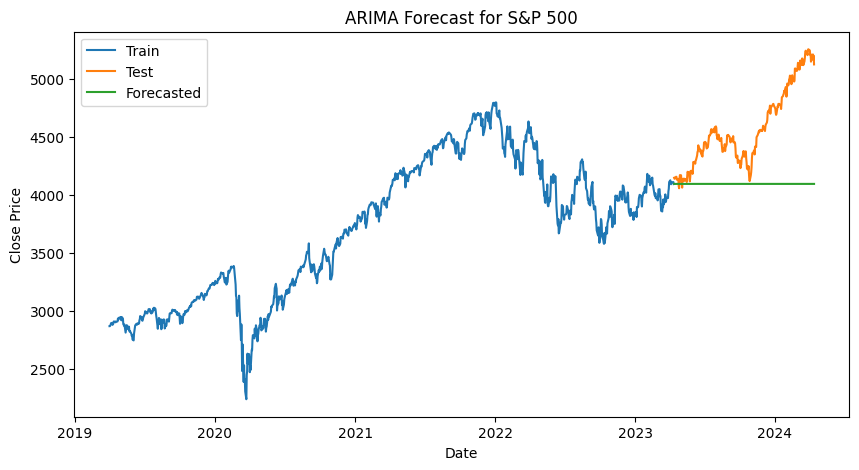

In [ ]:
model = ARIMA(sp_train_df['Close'], order=(1, 1, 1))
fitted_model = model.fit()

predictions = fitted_model.forecast(steps=len(sp_test_df))

plt.figure(figsize=(10, 5))
plt.plot(sp_train_df['Close'].index, sp_train_df['Close'], label='Train')
plt.plot(sp_test_df['Close'].index, sp_test_df['Close'], label='Test')
plt.plot(sp_test_df['Close'].index, predictions, label='Forecasted')
plt.title('ARIMA Forecast for S&P 500')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

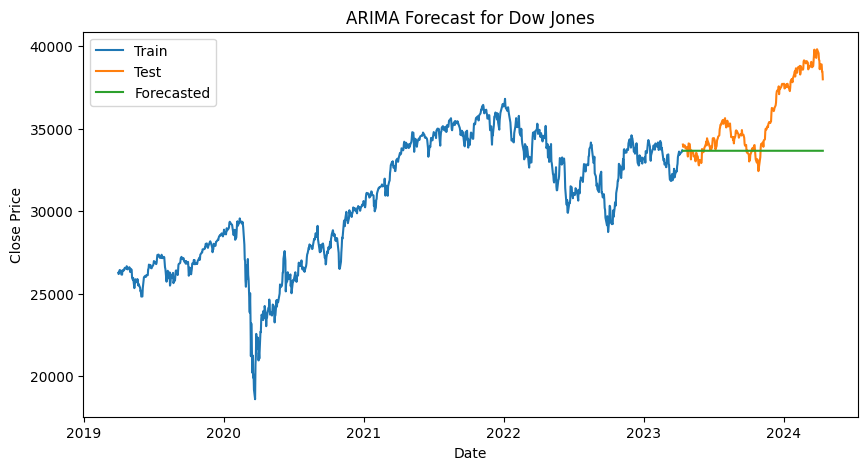

In [ ]:
model = ARIMA(dow_jones_train_df['Close'], order=(1, 1, 1))
fitted_model = model.fit()

predictions = fitted_model.forecast(steps=len(dow_jones_test_df))

plt.figure(figsize=(10, 5))
plt.plot(dow_jones_train_df['Close'].index, dow_jones_train_df['Close'], label='Train')
plt.plot(dow_jones_test_df['Close'].index, dow_jones_test_df['Close'], label='Test')
plt.plot(dow_jones_test_df['Close'].index, predictions, label='Forecasted')
plt.title('ARIMA Forecast for Dow Jones')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

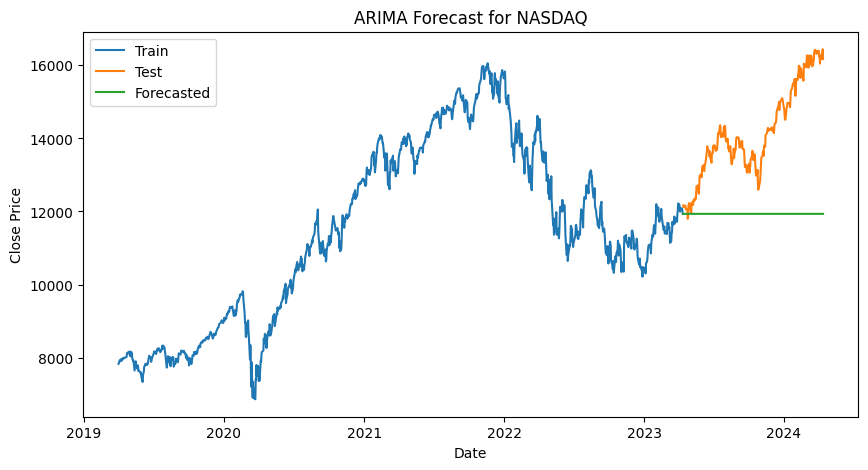

In [ ]:
model = ARIMA(nasdaq_train_df['Close'], order=(1, 1, 1))
fitted_model = model.fit()

predictions = fitted_model.forecast(steps=len(nasdaq_test_df))

plt.figure(figsize=(10, 5))
plt.plot(nasdaq_train_df['Close'].index, nasdaq_train_df['Close'], label='Train')
plt.plot(nasdaq_test_df['Close'].index, nasdaq_test_df['Close'], label='Test')
plt.plot(nasdaq_test_df['Close'].index, predictions, label='Forecasted')
plt.title('ARIMA Forecast for NASDAQ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Feature Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(sp_train_df[['Close']])
test_scaled = scaler.transform(sp_test_df[['Close']])

X_train = train_scaled[:-1]
y_train = train_scaled[1:]
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=1)

mlp_model.fit(X_train, y_train.ravel())


MLPRegressor(max_iter=500, random_state=1)

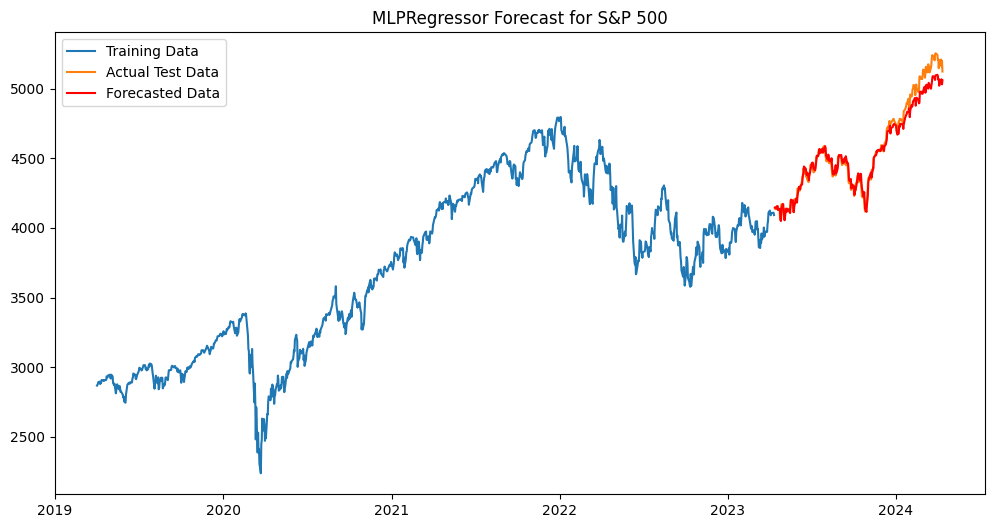

In [ ]:
y_pred_scaled = mlp_model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(sp_train_df.index[-len(y_train):], scaler.inverse_transform(y_train), label='Training Data')
plt.plot(sp_test_df.index[1:], sp_test_df['Close'].iloc[1:], label='Actual Test Data')
plt.plot(sp_test_df.index[1:], y_pred, label='Forecasted Data', color='red')
plt.title('MLPRegressor Forecast for S&P 500')
plt.legend()
plt.show()

In [ ]:
initial_input = test_scaled[-1].reshape(1, -1)

future_dates_april = pd.date_range(start='2024-04-15', periods=5, freq='B')

incremental_predictions = []
current_input = initial_input
for _ in range(5):
    next_pred = mlp_model.predict(current_input)
    incremental_predictions.append(next_pred)
    current_input = np.array([next_pred])

incremental_predictions_scaled = scaler.inverse_transform(incremental_predictions)

mlp_future_predictions = pd.Series(incremental_predictions_scaled.ravel(), index=future_dates_april)
mlp_future_predictions


2024-04-15    5003.999889
2024-04-16    4916.130505
2024-04-17    4849.772130
2024-04-18    4798.909180
2024-04-19    4758.759163
Freq: B, dtype: float64

In [ ]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(dow_jones_train_df[['Close']])
test_scaled = scaler.transform(dow_jones_test_df[['Close']])

X_train = train_scaled[:-1]
y_train = train_scaled[1:]
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=1)

mlp_model.fit(X_train, y_train.ravel())

MLPRegressor(max_iter=500, random_state=1)

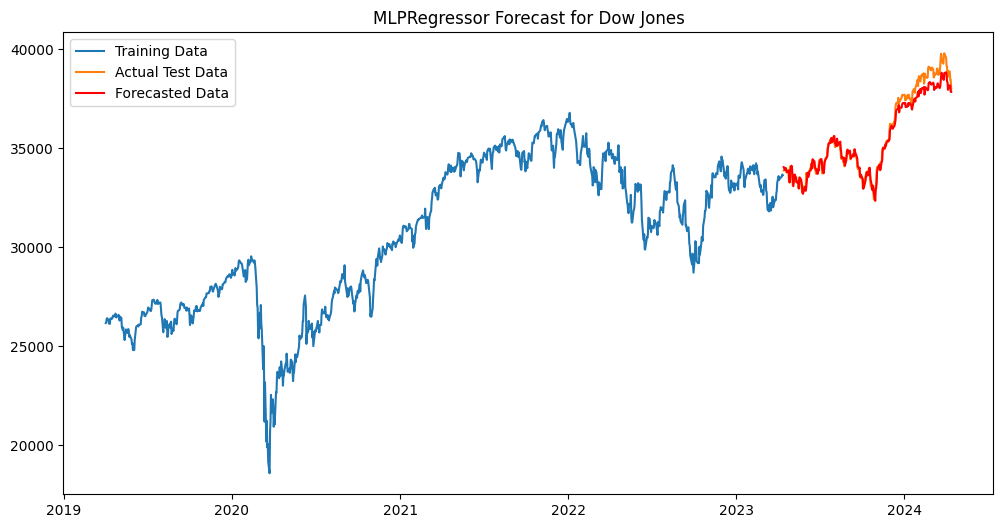

In [ ]:
y_pred_scaled = mlp_model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(dow_jones_train_df.index[-len(y_train):], scaler.inverse_transform(y_train), label='Training Data')
plt.plot(dow_jones_test_df.index[1:], dow_jones_test_df['Close'].iloc[1:], label='Actual Test Data')
plt.plot(dow_jones_test_df.index[1:], y_pred, label='Forecasted Data', color='red')
plt.title('MLPRegressor Forecast for Dow Jones')
plt.legend()
plt.show()

In [ ]:
initial_input = test_scaled[-1].reshape(1, -1)
future_dates_april = pd.date_range(start='2024-04-15', periods=5, freq='B')

incremental_predictions = []
current_input = initial_input
for _ in range(5):
    next_pred = mlp_model.predict(current_input)
    incremental_predictions.append(next_pred)
    current_input = np.array([next_pred])

incremental_predictions_scaled = scaler.inverse_transform(incremental_predictions)

mlp_future_predictions = pd.Series(incremental_predictions_scaled.ravel(), index=future_dates_april)
mlp_future_predictions

2024-04-15    37501.150477
2024-04-16    37139.868298
2024-04-17    36869.120218
2024-04-18    36661.225959
2024-04-19    36490.773034
Freq: B, dtype: float64

In [ ]:
# Feature Scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(nasdaq_train_df[['Close']])
test_scaled = scaler.transform(nasdaq_test_df[['Close']])

X_train = train_scaled[:-1]
y_train = train_scaled[1:]
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=1)

mlp_model.fit(X_train, y_train.ravel())

MLPRegressor(max_iter=500, random_state=1)

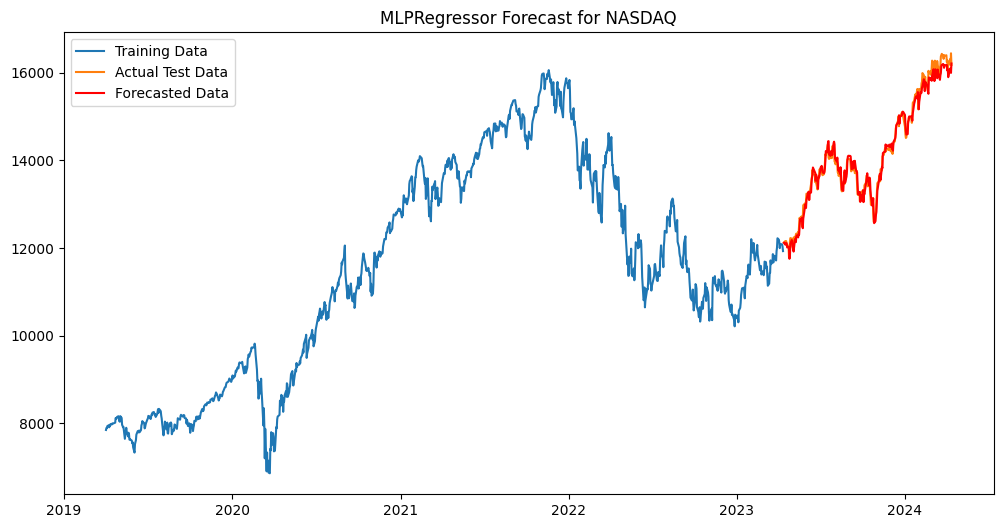

In [ ]:
y_pred_scaled = mlp_model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(nasdaq_train_df.index[-len(y_train):], scaler.inverse_transform(y_train), label='Training Data')
plt.plot(nasdaq_test_df.index[1:], nasdaq_test_df['Close'].iloc[1:], label='Actual Test Data')
plt.plot(nasdaq_test_df.index[1:], y_pred, label='Forecasted Data', color='red')
plt.title('MLPRegressor Forecast for NASDAQ')
plt.legend()
plt.show()

In [ ]:
initial_input = test_scaled[-1].reshape(1, -1)
future_dates_april = pd.date_range(start='2024-04-15', periods=5, freq='B')

incremental_predictions = []
current_input = initial_input
for _ in range(5):
    next_pred = mlp_model.predict(current_input)
    incremental_predictions.append(next_pred)
    current_input = np.array([next_pred])

incremental_predictions_scaled = scaler.inverse_transform(incremental_predictions)

mlp_predictions = pd.Series(incremental_predictions_scaled.ravel(), index=future_dates_april)
mlp_predictions

2024-04-15    15998.441155
2024-04-16    15855.915325
2024-04-17    15740.920858
2024-04-18    15648.139588
2024-04-19    15573.216819
Freq: B, dtype: float64